 # Chasing Limit Up/Down Events with Quantitative Models
Author: HUANG Wenjin 

Tutor: Hongsong CHOU, HKUST

Date: 23/5/2021

Key words: Data reprocess, Ensemble Tree Model, Chasing limit-up model, Portfolio weighted in balanced stocks value weighted

## Data Loading

In [1]:
import math
import os.path
import gzip
import pandas as pd
import numpy as np
import gc
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import math

In [2]:
# 模型保存路径
model_file = 'D:/Python/测试文件/Independent/model/'
# dir_path = 'D:/Python/测试文件/Independent'

# 数据集加载路径
dir_path = 'D:/Python/测试文件/Independent'

In [3]:
def data_cleaning(data, k=12):
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data = data.drop('stopMatch', axis=1)
    data = data.fillna(0)
    index_date = data['date'].unique()
#     print(associate)
    x = np.zeros((len(index_date),21))
    y = np.zeros((len(index_date)))
#     stock = [stock_num]*len(index_date)
    for i in range(len(index_date)):
        sub_data = data.loc[data['date']==index_date[i]]
        x_data = sub_data.loc[sub_data['testMatch']==1]
        x_data = x_data.drop(['date','time','lastPx','size','volume','testMatch'], axis=1)
        if len(x_data)==0:
            np.delete(x, i, axis=0)
            i -= 1
            continue
        elif x_data.shape[0] < k:
            x[i,:] = x_data.values[0,:]
        else:
            x[i,:] = x_data.values[-k,:]
            
        y_data = sub_data.iloc[-1:]
        y_data = y_data.drop(['date','time'], axis=1)
        if y_data.iloc[:,3:8].sum(axis=1).all() == 0:
            y[i] = 1
        elif y_data.iloc[:,8:13].sum(axis=1).all() == 0:
            y[i] = -1
    MinMaxScaler().fit_transform(x)
    return x, y

In [4]:
def read_single_file(dir_path, stock_num):
    files = sorted(os.listdir(dir_path))
    gc.collect()
    with gzip.open(dir_path + '/' + stock_num + '_openUpDnLimit_201801_201812.csv.gz', 'rt') as f:
        df1 = pd.read_csv(f)
    with gzip.open(dir_path + '/' + stock_num + '_openUpDnLimit_201901_201909.csv.gz', 'rt') as f:  
        df2 = pd.read_csv(f)
    df = df1.append(df2)
    x, y = data_cleaning(df)
    return x, y


In [5]:
def read_gzfile(dir_path):
    files = sorted(os.listdir(dir_path))
    embeddings, labels = [], []
    for file in files:
        print('Reading file {0}...........'.format(file))
        gc.collect()
        with gzip.open(dir_path + '/' + file, 'rt') as f:
            df = pd.read_csv(f)
            stock_num = file.split('_')[0]
            x_df, y_df= data_cleaning(df)
        embeddings.append(x_df)
        labels.append(y_df)
    X, Y = np.concatenate(embeddings), np.concatenate(labels)
    gc.collect()
    return X, Y


Here I load preopening data and split **k** data files by **last k** sample of each day, containing all stocks

In [6]:
# Data loading and formating
# x, y =read_gzfile(dir_path + '/preopening_data')

## Data Storing and Reprocess

I use ***pickle*** to store all the loaded data as **pkl files**, in order to import quicker.

In [7]:
import pickle

In [8]:
# # Data output
# data_output = open(model_file + 'model_x12.pkl','wb')
# pickle.dump(x,data_output)
# data_output.close()

# data_output = open(model_file + 'model_y.pkl','wb')
# pickle.dump(y,data_output)
# data_output.close()


In [9]:
# Data input
data_input = open(model_file + 'model_x1.pkl','rb')
x = pickle.load(data_input)
data_input.close()

data_input = open(model_file + 'model_y.pkl','rb')
y = pickle.load(data_input)
data_input.close()

data_input = open(model_file + 'stock_num.pkl','rb')
stocks = pickle.load(data_input)
data_input.close()

data_input = open(model_file + 'date.pkl','rb')
date = pickle.load(data_input)
data_input.close()

In [10]:
# Train and Test set split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Decision Tree

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, log_loss, confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
import graphviz 
import os
import matplotlib.pyplot as plt
from itertools import cycle

In [12]:
from sklearn import tree
import graphviz
decision = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4 ,min_samples_leaf=1)
decision
# it shows the default parameters

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
decision.fit(x_train,y_train)
dt_pr=decision.predict(x_test)

After **Grid search** for the corresponed parameters for base model, it can no longer be used.

In [14]:
# # GridsearchCV for decisioin tree

# max_depth = range(1,10,1)
# min_samples_leaf = range(1,10,2)
# tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

# from sklearn.model_selection import GridSearchCV
# decision = GridSearchCV(decision, tuned_parameters,cv=10)
# decision.fit(x_train,y_train)

# print("Best: %f using %s" % (decision.best_score_, decision.best_params_))

# dt_pr=decision.predict(x_test)

 I use a additional plug-in called **Graphviz** which can visualize the split way of tree model. Here is the tree model used only last data of each day.

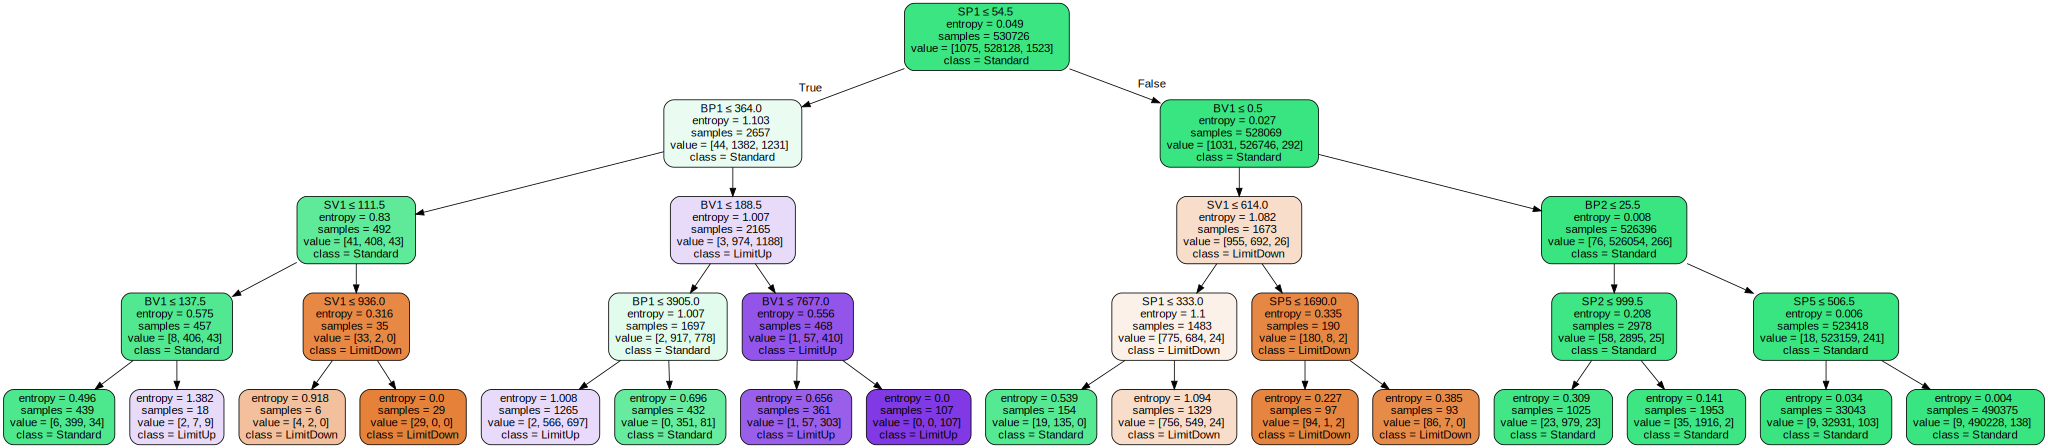

In [15]:
feature_names=['SP5','SP4','SP3','SP2','SP1','BP1','BP2','BP3','BP4','BP5','SV5','SV4','SV3','SV2','SV1','BV1','BV2','BV3','BV4','BV5','filledFlag']
class_names=['LimitDown','Standard','LimitUp']
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
dot_data = tree.export_graphviz(decision, out_file=None, 
                         feature_names = feature_names,  
                         class_names = class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph

In [16]:
dt_pr[1000:1500]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [17]:
confusion_matrix(y_test,dt_pr)

array([[   215,     33,      1],
       [   129, 131778,    140],
       [     7,    101,    278]], dtype=int64)

In [18]:
print (classification_report(y_test, dt_pr))

              precision    recall  f1-score   support

        -1.0       0.61      0.86      0.72       249
         0.0       1.00      1.00      1.00    132047
         1.0       0.66      0.72      0.69       386

    accuracy                           1.00    132682
   macro avg       0.76      0.86      0.80    132682
weighted avg       1.00      1.00      1.00    132682



In [19]:
dt_proba=decision.predict_proba(x_test)
log_loss(y_test,dt_proba) 

0.009762841474634108

In [20]:
# Compute ROC curve and ROC area for each class
num_classes = 3
y_test_onehot = LabelBinarizer().fit_transform(y_test)
fpr = dict()
tpr = dict()
threshold = dict()
optimal_threshold = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_onehot[:, i], dt_proba[:, i])
#     optimal_threshold[i] = Find_Optimal_Cutoff(fpr[i], tpr[i], threshold[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), dt_proba.ravel()) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr +=  np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# print('标签：最佳阈值',optimal_threshold)

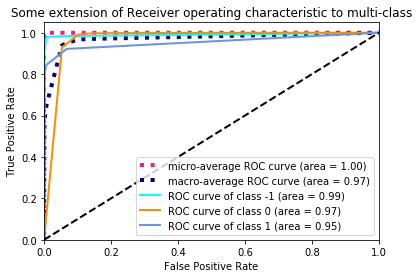

In [21]:
# Plot all ROC curves
lw = 2 # linewidth
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

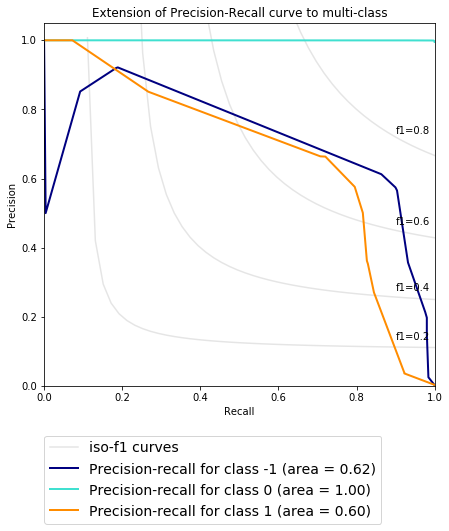

In [22]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_onehot[:, i],
                                                        dt_proba[:, i])
    average_precision[i] = average_precision_score(y_test_onehot[:, i], dt_proba[:, i])

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for i, color in zip(range(num_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i-1, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Ensemble Tree

In here, I just simply add all the base model up, it is not bagging or boosting method but a **naive** way to ***benchmark*** !

In [23]:
# sample: Number of sample in each day, one sample has only one tree in the model.
# train_timestep: Array of days used as train data, when it is zero, the whole data would be split randomly as train and test.
# data_dim: Number output predict results.
# test_timestep: Array of days used as test data, when it is zero, the other data will be set as test data.
def ensemble_tree_model(sample, train_timestep=[], data_dim=3, test_timestep=[]):
    w1, w2, w3, w4, w5, w6, w7, w8 = 0.85, 0.05, 0.025, 0.025, 0.0125, 0.0125, 0.0125, 0.0125
    
    y_score_zero = np.zeros((132682,data_dim))
    data_input = open(model_file + 'model_y.pkl','rb')
    y = pickle.load(data_input)
    data_input.close()
    data_input = open(model_file + 'date.pkl','rb')
    date = pickle.load(data_input)
    data_input.close()
    data_input = open(model_file + 'stock_num.pkl','rb')
    stock = pickle.load(data_input)
    data_input.close()
    
    y_train = y[np.isin(date,train_timestep)]
    if len(test_timestep)==0:
        y_test = y[~np.isin(date,train_timestep)]
        stock = stock[~np.isin(date,train_timestep)]
    else:
        y_test = y[np.isin(date,test_timestep)]
        stock = stock[np.isin(date,test_timestep)]
    y_score = np.zeros((len(y_test),data_dim))
    names = locals()
    for k in range(1,sample+1):
        data_input = open(model_file + 'model_x' + str(k) + '.pkl','rb')
        x = pickle.load(data_input)
        data_input.close()
        if len(train_timestep)==0:
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
            names['decision' + str(k) ] = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4 ,min_samples_leaf=1)
            names['decision' + str(k) ].fit(x_train,y_train)
            names['dt_proba' + str(k)]=names['decision' + str(k)].predict_proba(x_test)
            w, proba = names['w'+str(k)], names['dt_proba'+str(k)]  # Simply sum up the prediction
            y_score_zero += w*proba
        else:
            x_train = x[np.isin(date,train_timestep),:]
            if len(test_timestep)==0:
                x_test = x[~np.isin(date,train_timestep),:]
            else:
                x_test = x[np.isin(date,test_timestep),:]
            names['decision' + str(k) ] = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4 ,min_samples_leaf=1)
            names['decision' + str(k) ].fit(x_train,y_train)
            names['dt_proba' + str(k)]=names['decision' + str(k)].predict_proba(x_test)
            w, proba = names['w'+str(k)], names['dt_proba'+str(k)]  # Simply sum up the prediction
            y_score += w*proba
        print('The NO.{0} tree got loaded ...'
              ''.format(k))
    if len(train_timestep)==0:
        return y_score_zero, y_test, stock
    else: 
        return y_score, y_test, stock

In [24]:
date_index = np.unique(date)
train_timestep = date_index[0:400]

In [25]:
y_score, y_test, stock = ensemble_tree_model(sample=8, train_timestep=train_timestep)

The NO.1 tree got loaded ...
The NO.2 tree got loaded ...
The NO.3 tree got loaded ...
The NO.4 tree got loaded ...
The NO.5 tree got loaded ...
The NO.6 tree got loaded ...
The NO.7 tree got loaded ...
The NO.8 tree got loaded ...


In [26]:
# Compute ROC curve and ROC area for each class
num_classes = 3
y_test_onehot = LabelBinarizer().fit_transform(y_test)
fpr = dict()
tpr = dict()
threshold = dict()
optimal_threshold = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_onehot[:, i], y_score[:, i])
#     optimal_threshold[i] = Find_Optimal_Cutoff(fpr[i], tpr[i], threshold[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_score.ravel()) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr +=  np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# print('标签：最佳阈值',optimal_threshold)

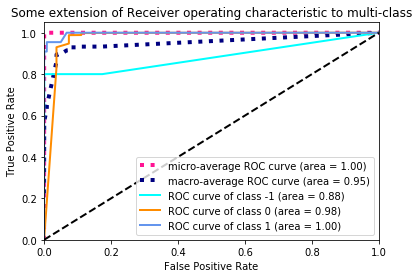

In [27]:
# Plot all ROC curves
lw = 2 # linewidth
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

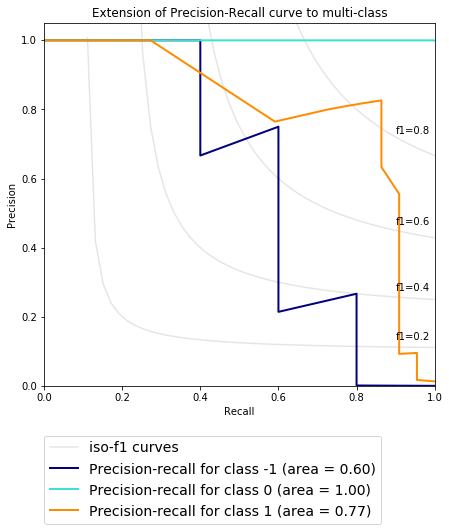

In [28]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
threshold = dict()
f1 = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], threshold[i] = precision_recall_curve(y_test_onehot[:, i],
                                                        y_score[:, i])
    f1[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
    average_precision[i] = average_precision_score(y_test_onehot[:, i], y_score[:, i])

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

for i, color in zip(range(num_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i-1, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

Interestingly, This method quietly work on ***Limit up*** stocks finding, which is the **label "1"** in classicifaction. Butit is even worse than baseline model when working on ***Limit down*** one.

In [29]:
# Threshold Selection
best_up_threshold = threshold[2][np.argmax(f1[2])]
best_down_threshold = threshold[0][np.argmax(f1[0])]
print('The best threshold for Limit up predict is:', best_up_threshold)
print('The best threshold for Limit down predict is:', best_down_threshold)

The best threshold for Limit up predict is: 0.21443535434745117
The best threshold for Limit down predict is: 0.7479265514271326


## Back Test for Single Stock

In [30]:
import pytz
from pytz import timezone

timestep = 400
bt1 = pd.read_csv(dir_path + '/backtest/ohlc_2018.csv')
bt2 = pd.read_csv(dir_path + '/backtest/ohlc_2019.csv')

backtest_stock = '0058'
backtest_files = ['s' + backtest_stock]
ohlc = bt1.append(bt2)
ohlc = ohlc.loc[ohlc['ticker'].isin(backtest_files)]
# bt = bt.drop(bt[bt['date']=='2018/1/2'].index)
ohlc = ohlc.iloc[timestep:]
ohlc

,Unnamed: 0,date,ticker,openPx,highPx,lowPx,closePx,value,volume,vwap
185309,0,2019-09-18,s0058,4663,4677,4662,4676,144796,31,4670.838710
186348,0,2019-09-19,s0058,4697,4697,4688,4688,112548,24,4689.500000
187551,0,2019-09-20,s0058,4705,4705,4703,4703,98765,21,4703.095238
188389,0,2019-09-23,s0058,4720,4720,4710,4710,103640,22,4710.909091
189592,0,2019-09-24,s0058,4710,4710,4698,4698,98670,21,4698.571429
190892,0,2019-09-25,s0058,4666,4666,4666,4666,93320,20,4666.000000
191837,0,2019-09-26,s0058,4700,4700,4664,4675,112192,24,4674.666667
192799,0,2019-09-27,s0058,4655,4673,4628,4673,16230812,3506,4629.438677


In [31]:
def classification(y_score, threshold1, threshold2):
    y_pred = np.zeros(len(y_score))
    i1 = np.where(y_score[:,2] > threshold1)
    i2 = np.where(y_score[:,0] > threshold2)
    y_pred[i2] = -1
    y_pred[i1] = 1
    return y_pred

In [32]:
date_index = np.unique(date)
stock_index = np.unique(stocks)

In [33]:
# back test decision tree process
y_pred = np.zeros((ohlc.shape[0]))
for i in range(ohlc.shape[0]): 
    train_timestep = date_index[~np.isin(date_index,ohlc['date'].values[i:])]
    test_timestep = ohlc['date'].values[i]
    print('Training data before the Date of ', test_timestep, ' ,model loading...')
    y_score, _, stock = ensemble_tree_model(sample=8, train_timestep=train_timestep, test_timestep=test_timestep)
    y_score= y_score[np.isin(stock,backtest_stock)]
    y_pred[i] = classification(y_score, best_up_threshold, best_down_threshold)

Training data before the Date of  2019-09-18  ,model loading...
The NO.1 tree got loaded ...
The NO.2 tree got loaded ...
The NO.3 tree got loaded ...
The NO.4 tree got loaded ...
The NO.5 tree got loaded ...
The NO.6 tree got loaded ...
The NO.7 tree got loaded ...
The NO.8 tree got loaded ...
Training data before the Date of  2019-09-19  ,model loading...
The NO.1 tree got loaded ...
The NO.2 tree got loaded ...
The NO.3 tree got loaded ...
The NO.4 tree got loaded ...
The NO.5 tree got loaded ...
The NO.6 tree got loaded ...
The NO.7 tree got loaded ...
The NO.8 tree got loaded ...
Training data before the Date of  2019-09-20  ,model loading...
The NO.1 tree got loaded ...
The NO.2 tree got loaded ...
The NO.3 tree got loaded ...
The NO.4 tree got loaded ...
The NO.5 tree got loaded ...
The NO.6 tree got loaded ...
The NO.7 tree got loaded ...
The NO.8 tree got loaded ...
Training data before the Date of  2019-09-23  ,model loading...
The NO.1 tree got loaded ...
The NO.2 tree got l

In [34]:
# backtest start
ohlc['pred'] = y_pred
ohlc['date'] = pd.to_datetime(ohlc['date'])
ohlc = ohlc.set_index('date')
Mt_Gambier= timezone('asia/shanghai')
ohlc.index = ohlc.index.tz_localize('UTC').tz_convert(Mt_Gambier)

In [35]:
def backtest_single(ohlc):
    
    df=pd.DataFrame()                                           # New DataFrame
    df['openPx']=ohlc['openPx']                                     # Open price
    df['pred']=ohlc['pred']  
    df['change']=ohlc['openPx']-ohlc['openPx'].shift(1)           # Change of Open price each day

    # Position
    df['pos']=0  # Initialization

    # Buy in Signal
    df['buy_size'] = 1
    df['pos'][df['pred']==1] = df['buy_size']
    df['pos'][df['pred']!=1] = 0
    df['pos']=df['pos'].shift(1).fillna(0)

    # Daily PNL and fee to trade
    df['pnl']=df['pos']*df['change']

    df['fee']=0  # set fee as 0
    # df['fee'][df['pos']!=df['pos'].shift(1)]=20000*df['closePx']*3/10000

    df['netpnl']=df['pnl']-df['fee']

    #   cumsum daily PNL
    df['cumpnl']=df['netpnl'].cumsum()
    return df

D:\Python\Anaconda3\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
D:\Python\Anaconda3\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


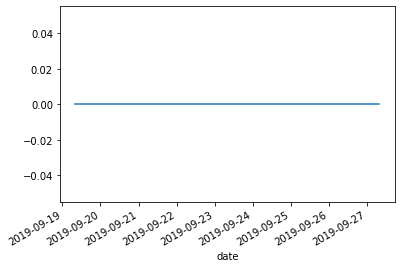

In [36]:
df = backtest_single(ohlc)
df['cumpnl'].plot()

In [37]:
df

,openPx,pred,change,pos,buy_size,pnl,fee,netpnl,cumpnl
date,,,,,,,,,
2019-09-18 08:00:00+08:00,4663,0.0,NaN,0.0,1,NaN,0,NaN,NaN
2019-09-19 08:00:00+08:00,4697,0.0,34.0,0.0,1,0.0,0,0.0,0.0
2019-09-20 08:00:00+08:00,4705,0.0,8.0,0.0,1,0.0,0,0.0,0.0
2019-09-23 08:00:00+08:00,4720,0.0,15.0,0.0,1,0.0,0,0.0,0.0
2019-09-24 08:00:00+08:00,4710,0.0,-10.0,0.0,1,-0.0,0,-0.0,0.0
2019-09-25 08:00:00+08:00,4666,0.0,-44.0,0.0,1,-0.0,0,-0.0,0.0
2019-09-26 08:00:00+08:00,4700,0.0,34.0,0.0,1,0.0,0,0.0,0.0
2019-09-27 08:00:00+08:00,4655,0.0,-45.0,0.0,1,-0.0,0,-0.0,0.0


## Back Test for Portfolio

In this stage, we combine all the stocks to analysis. There are mainly two steps. First, I compute all the **prediction** of each stocks in the trading days. Secondly, I decided the **ingredients of the portfolio** each trading days, by **tradable ratio**, **limit-up signal** and **capital amout limit**, to generate ***buy-in signal***.

In [38]:
timestep = 200
trading_date = date_index[timestep:]
trading_date

array(['2018-10-26', '2018-10-29', '2018-10-30', '2018-10-31',
       '2018-11-01', '2018-11-02', '2018-11-05', '2018-11-06',
       '2018-11-07', '2018-11-08', '2018-11-09', '2018-11-12',
       '2018-11-13', '2018-11-14', '2018-11-15', '2018-11-16',
       '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
       '2018-11-23', '2018-11-26', '2018-11-27', '2018-11-28',
       '2018-11-29', '2018-11-30', '2018-12-03', '2018-12-04',
       '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-10',
       '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14',
       '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
       '2018-12-21', '2018-12-22', '2018-12-24', '2018-12-25',
       '2018-12-26', '2018-12-27', '2018-12-28', '2019-01-02',
       '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08',
       '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14',
       '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18',
       '2019-01-21', '2019-01-22', '2019-01-23', '2019-

In [39]:
# # back test decision tree process
# y_pred = np.zeros((trading_date.shape[0],stock_index.shape[0]))
# for i in range(trading_date.shape[0]): 
#     train_timestep = date_index[~np.isin(date_index,trading_date[i:])]
#     test_timestep = trading_date[i]
#     print('Training data before the Date of ', test_timestep, ' ,model loading...')
#     y_score, _, stock = ensemble_tree_model(sample=8, train_timestep=train_timestep, test_timestep=test_timestep)
#     for j in range(stock_index.shape[0]):
#         y_score_stock = y_score[np.isin(stock,stock_index[j])]
#         if len(y_score_stock)!=0:
#             y_pred[i,j] = classification(y_score_stock, best_up_threshold, best_down_threshold)

In [40]:
# # Predict Data output
# data_output = open(model_file + 'backtest_prediction.pkl','wb')
# pickle.dump(y_pred,data_output)
# data_output.close()

In [41]:
# Predict Data input
data_input = open(model_file + 'backtest_prediction.pkl','rb')
y_pred = pickle.load(data_input)
data_input.close()

In [42]:
def backtest_portfolio(ohlc, capital=1000000, p=0.5):
    # p is the tradable ratio of each stocks
    
    df=pd.DataFrame()                                           # New DataFrame
    df['openPx']=ohlc['openPx']                                     # Open Price
    df['change']=ohlc['Next_OpenPrice']-ohlc['openPx']           # Change of Open price each day
    df['Last5_MovingMedian']=(p*ohlc['Last5_MovingMedian']).astype(int)

    # Position
    df['pos']=0  # Initialization

    # Buy in Signal
    stock_num = len(np.unique(ohlc['ticker'].values))
    value_per_stock = capital/stock_num
    df['pre_pos'] = (value_per_stock/df['openPx']).astype(int)   # Make the pre-postion to be int shares 
    df['buy_size'] = df[['pre_pos','Last5_MovingMedian']].min(axis=1)
    df['pos'] = df['buy_size']

    # Daily PNL and fee to trade
    df['pnl']=df['pos']*df['change']

    df['fee']=0  # set fee as 0
    # df['fee'][df['pos']!=df['pos'].shift(1)]=20000*df['closePx']*3/10000

    df['netpnl']=df['pnl']-df['fee']

    return df

Now we try to backtest within a single day. And I find saome problem.

1. Some stocks **early stopped trading** on the market before the trading process end. I have to get rid of them by filtering their acceptable days in the portfolio, shown under the below code as an example of these **early stopped trading** stocks:

2. I use the **moving median of past 5 days' trading volume** on the market and the **p : tradable ratio** to simulate the chasing limit up buying process. initalizing the $p = 0.5$, I try to adjust this parameter to verify the model performance in different market enviornment.

In [48]:
# Trading stocks tables, showing a demo for a particular trading day
d = 127
ohlc = bt1.append(bt2)
date = trading_date[d]
ohlc = ohlc.iloc[np.isin(ohlc['date'].values,date)]
ohlc = ohlc.sort_values(by=['ticker','date'])
Up_stock = stock_index[y_pred[d,:]==1]
for i in range(len(Up_stock)):
    Up_stock[i] = 's' + Up_stock[i]
ohlc = ohlc.loc[ohlc['ticker'].isin(Up_stock)]
last_and_next_ohlc = bt1.append(bt2)
last_and_next_ohlc = last_and_next_ohlc.iloc[np.isin(last_and_next_ohlc['ticker'].values,ohlc['ticker'].values)]
last_and_next_ohlc = last_and_next_ohlc.sort_values(by=['ticker','date'])
this_day =np.isin(last_and_next_ohlc['date'].values,trading_date[d])
next_day = np.insert(np.delete(this_day,-1),0,False)
ohlc['Next_OpenPrice'] = last_and_next_ohlc['openPx'].iloc[next_day].values
ohlc['Last5_MovingMedian'] = last_and_next_ohlc['volume'].rolling(5).median().iloc[this_day].values
df = backtest_portfolio(ohlc, capital=1000000)
print('Sum of Pnl for this portfolio today is: ', sum(df['netpnl'].values))
ohlc

Sum of Pnl for this portfolio today is:  8721468


,Unnamed: 0,date,ticker,openPx,highPx,lowPx,closePx,value,volume,vwap,Next_OpenPrice,Last5_MovingMedian
86441,0,2019-05-10,s0059,4479,4479,4470,4470,31344,7,4477.714286,4444,4.0
86176,0,2019-05-10,s1443,708,710,708,708,80054,113,708.442478,706,113.0
85873,0,2019-05-10,s1465,1675,1675,1455,1465,4135905,2645,1563.669187,1465,198.0
86450,0,2019-05-10,s2475,17,17,16,17,855820,52457,16.314696,1500,38612.0
264234,0,2019-05-10,s3465,2810,2850,2810,2850,8510,3,2836.666667,3090,3.0
263926,0,2019-05-10,s5455,2470,2480,2470,2480,4950,2,2475.000000,2480,2.0
264003,0,2019-05-10,s6144,1005,1005,997,997,4002,4,1000.500000,918,16.0
263780,0,2019-05-10,s6221,4290,4290,4290,4290,1994850,465,4290.000000,4670,46.0
263700,0,2019-05-10,s6523,6880,6880,6880,6880,1093920,159,6880.000000,7150,21.0
264171,0,2019-05-10,s6574,8000,8080,8000,8080,32240,4,8060.000000,8030,1.0


Here, **Stock NO. 2475** mistakes the *Next Open Price* because it is the last trading day in **2019-5-10**. So I need to filter this stock of its end day during trading simulation.

This is trading simulation for the all about 200 days, starting from **2018-10-26**. The code can easily output position of the portfolio each day. However, I would like to try more parameter tuning on ***p*** , so I would't show it.

In [44]:
# Trading stocks tables, showing a demo for a particular trading day
p = [0.1,0.3,0.5,0.7,0.9]  # Set the probability-like parameter p
daily_pnl = np.zeros((trading_date.shape[0]-1,len(p)))
max_drawdown, cumpnl = np.zeros((trading_date.shape[0]-1,len(p))), np.zeros((trading_date.shape[0]-1,len(p)))
diviation, sharp_ratio = np.zeros((trading_date.shape[0]-1,len(p))), np.zeros((trading_date.shape[0]-1,len(p)))
drawdown = np.zeros((len(p)))

int_captial = 1000000  # Set initial captial as one million
captial = int_captial*np.ones(len(p))
raw_ohlc = bt1.append(bt2)
for d in range(trading_date.shape[0]-1):
    count = 0
    print('Training data before the Date of ', trading_date[d], ' ,model loading...')
    date = trading_date[d]
    ohlc = raw_ohlc.iloc[np.isin(raw_ohlc['date'].values,date)]
    ohlc = ohlc.sort_values(by=['ticker','date'])
    Up_stock = stock_index[y_pred[d,:]==1]
    num = len(Up_stock)
    for i in range(num):
        Up_stock[i-count] = 's' + Up_stock[i-count]
        test_ohlc = raw_ohlc['date'].loc[raw_ohlc['ticker']==Up_stock[i-count]]
        if test_ohlc.iloc[-1]==date :
            Up_stock = np.delete(Up_stock,i-count)
            count += 1
    ohlc = ohlc.loc[ohlc['ticker'].isin(Up_stock)]
    if len(ohlc)==0:
        daily_pnl[d,:] = 0
        print('no stock to trade today!')
    else:
        last_and_next_ohlc = raw_ohlc.iloc[np.isin(raw_ohlc['ticker'].values,ohlc['ticker'].values)]
        last_and_next_ohlc = last_and_next_ohlc.sort_values(by=['ticker','date'])
        last_day = np.append(np.delete(np.isin(last_and_next_ohlc['date'].values,trading_date[d]),0),False)
        next_day = np.insert(np.delete(np.isin(last_and_next_ohlc['date'].values,trading_date[d]),-1),0,False)
        ohlc['Next_OpenPrice'] = last_and_next_ohlc['openPx'].iloc[next_day].values
        ohlc['Last5_MovingMedian'] = last_and_next_ohlc['volume'].rolling(5).median().iloc[last_day].values
        for j in range(len(p)):
            df = backtest_portfolio(ohlc, capital=captial[j], p=p[j])
            daily_pnl[d,j] = sum(df['netpnl'].values)
    for j in range(len(p)):
        captial[j] += daily_pnl[d,j]
        cumpnl[d,j] = captial[j] - int_captial
        diviation[d,j] = np.std(daily_pnl[:d,j])
        sharp_ratio[d,j] = cumpnl[d,j]/(diviation[d,j]/math.sqrt(len(trading_date)))
        drawdown[j] = 1-cumpnl[d,j]/np.max(cumpnl[:d+1,j],axis=0)
        max_drawdown[d,j] = max(np.max(max_drawdown[0:d+1,j],axis=0),drawdown[j])
        
        
        

Training data before the Date of  2018-10-26  ,model loading...


D:\Python\Anaconda3\envs\tf2.0\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Python\Anaconda3\envs\tf2.0\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Python\Anaconda3\envs\tf2.0\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training data before the Date of  2018-10-29  ,model loading...


D:\Python\Anaconda3\envs\tf2.0\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


Training data before the Date of  2018-10-30  ,model loading...
Training data before the Date of  2018-10-31  ,model loading...
Training data before the Date of  2018-11-01  ,model loading...
Training data before the Date of  2018-11-02  ,model loading...
Training data before the Date of  2018-11-05  ,model loading...
Training data before the Date of  2018-11-06  ,model loading...
Training data before the Date of  2018-11-07  ,model loading...
Training data before the Date of  2018-11-08  ,model loading...
Training data before the Date of  2018-11-09  ,model loading...
Training data before the Date of  2018-11-12  ,model loading...
Training data before the Date of  2018-11-13  ,model loading...
Training data before the Date of  2018-11-14  ,model loading...
Training data before the Date of  2018-11-15  ,model loading...
Training data before the Date of  2018-11-16  ,model loading...
Training data before the Date of  2018-11-19  ,model loading...
Training data before the Date of  2018-1

Training data before the Date of  2019-05-16  ,model loading...
Training data before the Date of  2019-05-17  ,model loading...
Training data before the Date of  2019-05-20  ,model loading...
Training data before the Date of  2019-05-21  ,model loading...
Training data before the Date of  2019-05-22  ,model loading...
Training data before the Date of  2019-05-23  ,model loading...
Training data before the Date of  2019-05-24  ,model loading...
Training data before the Date of  2019-05-27  ,model loading...
Training data before the Date of  2019-05-28  ,model loading...
Training data before the Date of  2019-05-29  ,model loading...
Training data before the Date of  2019-05-30  ,model loading...
Training data before the Date of  2019-05-31  ,model loading...
Training data before the Date of  2019-06-03  ,model loading...
Training data before the Date of  2019-06-04  ,model loading...
Training data before the Date of  2019-06-05  ,model loading...
Training data before the Date of  2019-0

Cumulative PNL doesn't contain the initial capital but only pure income from the portfolio

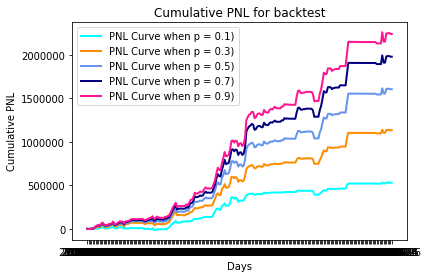

In [45]:
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
for i, color in zip(range(len(p)), colors):
    plt.plot(trading_date[0:-1], cumpnl[:,i], color=color, lw=2, 
             label='PNL Curve when p = {0:0.1f})'
             ''.format(p[i]))
plt.xlabel('Days')
plt.ylabel('Cumulative PNL')
plt.title('Cumulative PNL for backtest')
plt.legend(loc="upper left")
plt.show()

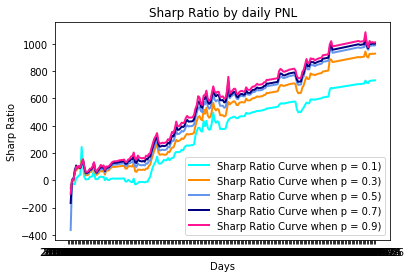

In [46]:
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
for i, color in zip(range(len(p)), colors):
    plt.plot(trading_date[0:-1], sharp_ratio[:,i], color=color, lw=2, 
             label='Sharp Ratio Curve when p = {0:0.1f})'
             ''.format(p[i]))
plt.xlabel('Days')
plt.ylabel('Sharp Ratio')
plt.title('Sharp Ratio by daily PNL')
plt.legend(loc="lower right")
plt.show()

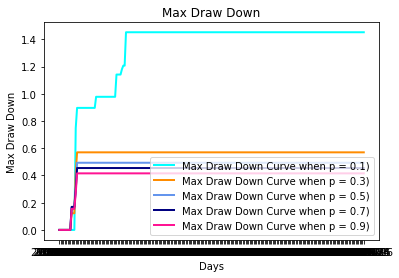

At p= 0.9 .The Largest Max Draw Down happened in  2018-11-14 , which reached to 41.56%


In [47]:
plt.figure()
for i, color in zip(range(len(p)), colors):
    plt.plot(trading_date[0:-1], max_drawdown[:,i], color=color, lw=2, 
             label='Max Draw Down Curve when p = {0:0.1f})'
             ''.format(p[i]))
plt.xlabel('Days')
plt.ylabel('Max Draw Down')
plt.title('Max Draw Down')
plt.legend(loc="lower right")
plt.show()
p_number = 5 # Print out the result of particualar p
print('At p=', p[p_number-1], '.The Largest Max Draw Down happened in ',trading_date[np.argmax(max_drawdown[:,p_number-1])] ,
      ', which reached to {:.2%}'.format(max(max_drawdown[:,p_number-1])))

## Summary Report and Further Planing

**Summary:** This entire model has 3 main parts in total,including **Benchmark prediction**, **Trading Signal Formating** and **Back Test Simulation**.

1. **Benchmark prediction:** I used reprocessed data, growing trees as benchmark to predict the next one day Limit up or down for all the stocks. The k.th tree used only the last k.th sample in each trading day. By this way, I can not only predict one day but also two days by past data. 

2. **Trading Signal Formating:** I tried the simple strategy,which means I will buy in the stocks predicted as **Limit-up** and sell them all during the next trading day. And the signal was processed by the benchmark model with past data before the traing day, no future information was contained. 

3. **Back Test Simulation:** Portfolio was seem as balanced value weight in each stock, which means I use the total capital to buy different shares of stocks but in the nearly same value. Portfolio was automatically adjust by the trading signal of models. And I set a tradable volume of each stock by **past 5 days' moving median** and the probability-like parameter ***p*** to simulate the back test process. The merits are **Cumulative PNL**, **Sharp Ratio by Daily PNL** and **Max Draw Down** in each parameters.

The rewards of the strategy is quiet well. Even in $p=0.1$ , the PNL rate can still reach 50% in the past 200 trading days. And the sharp ratio incresed obviously. However, the draw back of model when $p=0.1$ can worse perform on the market,with over 150% max draw back here. **So we need to make sure the trading system perform well enough otherwise we would suffer too large draw back!**

**Future Planing:** I would like to use ***LSTM*** as a **stacked model** works on more labels from tree models, predicting Limit up and down two days' after the trading days. Unfortunately, I wasted too much time on Keras, Tensorflow and LSTM. Then I can not fulfill this aim by combining benchmark and stacked models. 